In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.random.set_seed(42)

Vamos a probar a hacer un AutoEncoder desde 0 utilizando TensorFlow. La idea es que el AutoEncoder está compuesto por dos partes:

- La primera coge (en este caso) la imagen de input y la codifica. Se llama Encoder.
- La segunda coge la imagen codifica e intenta reconstruirla. Se llama Decoder.

La idea es que la codificación (o espacio latente) tenga un número suficiente de dimensiones como para que el Encoder pueda extraer las características necesarias para favorecer la reconstrucción posterior. De primeras vamos a ponerle 2 dimensiones al espacio latente para poder visualizarlo sin mucho problema, y trabajaremos utilizando el típico dataset de dígitos escritos a mano MNIST.

Para empezar cargamos el dataset con la ayuda de TensorFlow:

In [103]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

Podemos visualizar algunas de las imágenes para hacernos una idea de los datos con los que estamos tratando:

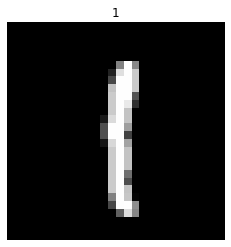

In [26]:
plt.figure()
sample = np.random.randint(X_train.shape[0])
plt.imshow(X_train[sample], cmap="gray")
plt.title(Y_train[sample])
plt.axis("off")
plt.show()

Vamos a hacer un reshape para que las imágenes estén "alargadas" a lo largo de una dimensión en lugar de tener dos dimensiones. También las normalizamos para que los valores estén entre 0 y 1, que es lo óptimo para una NN:

In [104]:
X_train = X_train / 255
X_test = X_test / 255

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

In [55]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

Aunque la forma "bien" de hacerlo es utilizando convoluciones, vamos a hacerlo primero utilizando capas densas porque es más fácil de entender y de montar todo. Empezaremos haciendo el Encoder:

## Functional API

In [186]:
#Input
input_img = tf.keras.layers.Input(shape = (784,), name = "Input")

#Encoder
encoder1 = tf.keras.layers.Dense(128, activation = "relu")
encoder2 = tf.keras.layers.Dense(64, activation = "relu")
encoder3 = tf.keras.layers.Dense(32, activation = "relu")
encoder4 = tf.keras.layers.Dense(2, activation = "relu")

#Decoder
decoder1 = tf.keras.layers.Dense(32, activation = "relu")
decoder2 = tf.keras.layers.Dense(64, activation = "relu")
decoder3 = tf.keras.layers.Dense(128, activation = "relu")
decoder4 = tf.keras.layers.Dense(784, activation = "relu")

#Codificación
encoded = encoder1(input_img)
encoded = encoder2(encoded)
encoded = encoder3(encoded)
encoded = encoder4(encoded)

#Decodificación
decoded = decoder1(encoded)
decoded = decoder2(decoded)
decoded = decoder3(decoded)
decoded = decoder4(decoded)

#Creamos el modelo
autoencoder = tf.keras.Model(input_img, decoded)

In [169]:
autoencoder.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense_81 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_82 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_83 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_84 (Dense)             (None, 2)                 66        
_________________________________________________________________
dense_85 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_86 (Dense)             (None, 64)              

In [187]:
autoencoder.compile(optimizer="adam", loss = "mean_squared_error")

In [188]:
history = autoencoder.fit(X_train, X_train, epochs = 50, batch_size = 256, shuffle = True, validation_data=(X_test, X_test))

Epoch 1/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0684 - val_loss: 0.0578
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0548 - val_loss: 0.0523
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0510 - val_loss: 0.0500
Epoch 4/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0491 - val_loss: 0.0476
Epoch 5/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0468 - val_loss: 0.0464
Epoch 6/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0458 - val_loss: 0.0456
Epoch 7/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0447 - val_loss: 0.0445
Epoch 8/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0439 - val_loss: 0.0439
Epoch 9/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0434 - val_loss: 0.0434
Epoch 10/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0431 - val_loss: 0.0432

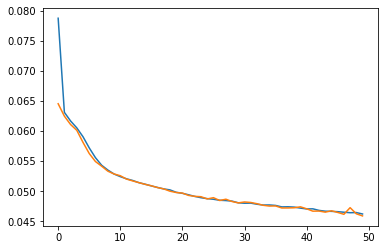

In [172]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

Ahora que ya hemos entrenado el AutoEncoder entero, podemos coger solamente la parte del encoder para ver cómo es el espacio latente:

In [189]:
encoder = tf.keras.Model(input_img, encoded)
encoder.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense_89 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_90 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_91 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_92 (Dense)             (None, 2)                 66        
Total params: 110,882
Trainable params: 110,882
Non-trainable params: 0
_________________________________________________________________


In [190]:
cuac = encoder.predict(X_test)
cuac_df = pd.DataFrame(cuac)
cuac_df["label"] = Y_test.astype(str)

In [118]:
import plotly.express as px

In [191]:
px.scatter(cuac_df, x = 0, y = 1, color = "label")

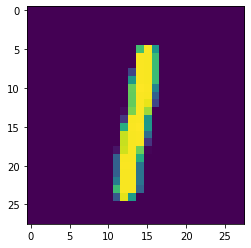

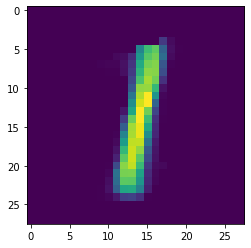

In [192]:
plt.figure()
#predictions = autoencoder.predict(X_test)
sample = np.random.randint(10000)
plt.imshow(X_test[sample].reshape(28,28))
plt.show()
plt.imshow(predictions[sample].reshape(28,28))
plt.show()

## Subclassing API

In [162]:
class Encoder(tf.keras.layers.Layer): #Heredamos de la clase Model porque vamos a crear un modelo
    def __init__(self):
        super(Encoder, self).__init__()

        #self.entrada = tf.keras.layers.Input(shape=(784,))
        self.encoder1 = tf.keras.layers.Dense(128, activation = "relu")
        self.encoder2 = tf.keras.layers.Dense(64, activation = "relu")
        self.encoder3 = tf.keras.layers.Dense(32, activation = "relu")
        self.encoder4 = tf.keras.layers.Dense(2, activation = "relu")
    
    def call(self, inputs, training = None, mask = None):
        #y = self.entrada(inputs)
        y = self.encoder1(inputs)
        y = self.encoder2(y)
        y = self.encoder3(y)
        y = self.encoder4(y)

        return y

In [198]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()

        self.decoder1 = tf.keras.layers.Dense(32, activation = "relu")
        self.decoder2 = tf.keras.layers.Dense(64, activation = "relu")
        self.decoder3 = tf.keras.layers.Dense(128, activation = "relu")
        self.decoder4 = tf.keras.layers.Dense(784, activation = "sigmoid")

    def call(self, inputs, training = None, mask = None):
        y = self.decoder1(inputs)
        y = self.decoder2(y)
        y = self.decoder3(y)
        y = self.decoder4(y)

        return y

In [199]:
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, inputs, training = None, mask = None):
        y = self.encoder(inputs)
        y = self.decoder(y)

        return y

In [200]:
ae = AutoEncoder()
ae.compile(optimizer="adam", loss = "mae")
ae.fit(X_train, X_train, batch_size=256, epochs = 50, validation_data=(X_test, X_test))

Epoch 1/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1467 - val_loss: 0.1250
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1179 - val_loss: 0.1167
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1150 - val_loss: 0.1150
Epoch 4/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1125 - val_loss: 0.1115
Epoch 5/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1093 - val_loss: 0.1090
Epoch 6/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1073 - val_loss: 0.1065
Epoch 7/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1050 - val_loss: 0.1046
Epoch 8/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1030 - val_loss: 0.1024
Epoch 9/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1014 - val_loss: 0.1011
Epoch 10/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1004 - val_loss: 0.1001

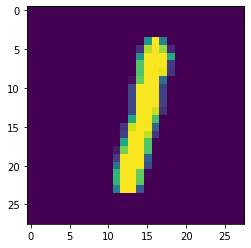

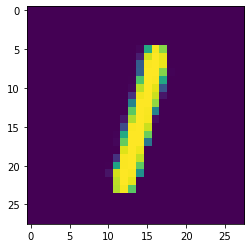

In [214]:
plt.figure()
#predictions = ae.predict(X_test)
sample = np.random.randint(10000)
plt.imshow(X_test[sample].reshape(28,28))
plt.show()
plt.imshow(predictions[sample].reshape(28,28))
plt.show()

In [215]:
cuac = ae.encoder(X_test)
cuac_df = pd.DataFrame(cuac.numpy())
cuac_df["label"] = Y_test.astype(str)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [217]:
px.scatter(cuac_df, x = 0, y = 1, color = "label")